# Hands-On Bayesian Modeling:

## Building and Fitting Predictive Models with PyMC

This notebook will introduce you to the basics of PyMC and Bayesian modeling, and show you how to build and fit a simple models to data. I have designed it so you will have maximal benefit from *actually* reading through it from A-Z (and not just hopping directly to the code and hacking away). But of course, you are free to do as you please.

You will work through the problems alone or in pairs/small groups, and I will reserve the last 10 minutes of the workshop to a summary presentation where I go over the key learnings of each notebook section.

After having completed this workshop you should be able to define and fit simple models in PyMC, know where to search for answers when you get stuck, and hopefully have a burning desire to try out Bayesian modeling in your day-to-day work 🤩.

> ## Setup instructions
>
> If you are on a machine with `conda` (or even better, `mamba`) installed, the easy way to get started is to create a new environment with all the necessary packages by running the following command in your terminal:
>
> ```bash
> mamba env create -f environment.yml  # or 'conda env create -f environment.yml' but that is slow
> conda activate bayesian-modelling
> ```
>
> But we don't have much time, so another good option is to simply do this tutorial in Colab. The notebook is available [here](https://colab.research.google.com/github/ulfaslak/bayesian-stats-modelling-workshop/blob/master/workshop.ipynb).
> 

## What is probabalistic programming?
In "regular" programming, variables are assigned *values*. The value of a variable may change due to the operations executed by the program, but at any given time they are specific values such as `7`, `42`, `None`, or `"ice_cream"`.

In probabilistic programming, things are a little... different. Instead of being hard-assigned to specific values, variables are assigned to *probability distributions*, and the program executes operations on these distributions. So if someone asks: *"what is the value of `a`"* your most accurate answer is *"probably zero"* (if the mean of its distribution is zero).
It sounds ridiculous, but it's actually awesome because it allows us to build models that can represent uncertainty in our data and our assumptions.

So where we might normally write:

```python
a = 2
b = 3
c = a + b
```

In probabilistic programming, we could write:

```python
a = Normal(mu=0, sigma=1)
b = Gamma(alpha=2, beta=1)  # Normal and Gamma are different types of probability distributions
c = a + b
```


<!DOCTYPE html>
<html>
<head>
    <script type="text/javascript" async
      src="https://cdn.jsdelivr.net/npm/mathjax@3/es5/tex-mml-chtml.js">
    </script>
</head>

<div style="border: 1px solid #d1e7dd; background-color: #d1e7dd; border-radius: 5px; padding: 10px; margin: 10px 0;">
    
<strong>For Nerds:</strong>

<p>This is especially useful when doing Bayesian inference, where we want to jointly consider our <i>apriori</i> beliefs about the parameters of our model, and the likelihood of the data given those parameters. Bayes' rule states:</p>

<p style="text-align: center;">
  \(P(\theta|D) \sim P(\theta)P(D|\theta)\)
</p>

<p>If we have a dead simple model like <code>y = θ * x</code>, where <code>y</code> and <code>x</code> make up the data <i>D</i>, the equivalent <i>probabilistic</i> code would look like this:</p>

<pre style="background-color: #f4f4f4; border: 1px solid #ddd; border-radius: 5px; padding: 10px;">
<code>
θ_prior = Normal(mu=0, sigma=1)
likelihood = Normal(mu=θ_prior * D_x, sigma=1, observed=D_y)
θ_posterior = θ_prior * likelihood
</code>
</pre>

</div>
</html>


## Using probabilistic variables in PyMC

PyMC is a Python library that implements probabilistic programming. It allows you to define models as Python code, and then fit those models to data using an optimization algorithm called *Markov Chain Monte Carlo* (MCMC). It has a simple and intuitive syntax, and is very flexible. Part of the magic to PyMC, is that you don't have to understand how the underlying mechanics of model fitting with MCMC works. It's cool and intuitive, but takes a while to wrap your head around so we will gloss over it in this workshop. But if you want a friendly introduction read [this blog post](https://twiecki.io/blog/2015/11/10/mcmc-sampling/) by Thomas Wiecki.

👇 Let's define the probabilistic variables that we used in the example above, but this time using PyMC:

In [1]:
import pymc as pm

with pm.Model():
    a = pm.Normal('a', mu=0, sigma=1)
    b = pm.Gamma('b', alpha=2, beta=1)
    c = a + b

`a`, `b`, and `c`, don't have fixed values, they are distributions, so to get some numbers out of them, we need to `draw` from them.

In [2]:
pm.draw(a)  # Try re-running this a couple times. What happens?

array(1.46605425)

> **Excercise 1:** Plot the distributions of `a`, `b`, and `c` by drawing many samples from each of them. 
> 
> *Hint: `pm.draw` takes an argument `draws`, which lets you draw multiple samples from the distribution at once.*

## Fitting models in PyMC

A model is a mathematical representation of a system. In *supervised* models, it is a mapping that tries to explain how an `x` leads to a `y`. 

For example, in a linear regression model, you might have a variable for the slope of the line, a variable for the intercept, and a variable for the noise in the data. These variables are related by the equation: `y = mx + b + σ`, where
* `y` is the outcome,
* `m` is the slope,
* `x` is the driver, 
* `b` is the baseline, and 
* `σ` is noise within the relation. 

You have probably fitted a regression model before, maybe using `sklearn`, `scipy`, or `statsmodels`. Let's compare how to do that in `scipy` and PyMC.

🎲 **First, we simulate some data**:

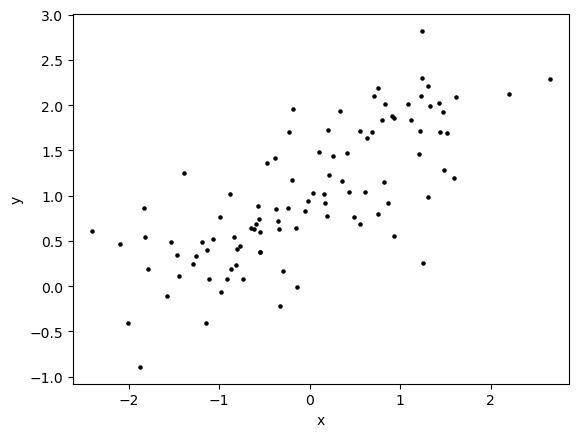

In [3]:
import numpy as np
import matplotlib.pylab as plt

N = 100
true_m = 0.5
true_b = 1
true_σ = np.random.normal(size=N) * true_m

x = np.random.normal(size=N)
y = true_m * x + true_b + true_σ

plt.scatter(x, y, s=5, c="k")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal");

### Linear regression in `scipy` 📈

This is straight forward. We can define the model as a Python function, fit it in one line, and print the result.

In [4]:
from scipy.optimize import curve_fit

# 1) Define the model
# -------------------
def linear_model(x, m, b):
    return m * x + b

# 2) Fit it!
# ----------
params_scipy, _ = curve_fit(linear_model, x, y)

# 3) Compare the fitted parameters to the true ones
# -------------------------------------------------
print("True values:")
print("\tm: ", true_m)
print("\tb: ", true_b)
print("\tσ (std): ", np.std(true_σ))

print("\nFit values:")
print("\tm: ", params_scipy[0])
print("\tb: ", params_scipy[1])
print("\tσ (std): ", np.std(y - linear_model(x, *params_scipy)))

True values:
	m:  0.5
	b:  1
	σ (std):  0.48855078035434973

Fit values:
	m:  0.5207725773478461
	b:  1.021450465380045
	σ (std):  0.48804729901485533


#### Linear regression in PyMC 🚀

This is also simple, but the syntax is different. Try running the cell below (if running locally, this is also a good test that your environment is set up correctly).

In [5]:
# 1) Define the model
# -------------------
with pm.Model() as model:
    m = pm.Normal('m', mu=0.5, sigma=1)
    b = pm.Normal('b', mu=1, sigma=1)
    σ = pm.HalfNormal('σ', sigma=0.5)

    y_pred = m * x + b
    
    pm.Normal('y_pred', mu=y_pred, sigma=σ, observed=y)

Before we fit the model and print parameters, let's consider the code through the following questions:

> **Excercise 2:**
> 
> Q 2.1: Each of the model parameters (`m`, `b`, and `σ`) is a probability distribution. What do we call these in Bayesian statistics?
> 
> Q 2.2: What is the significance of the probability distribution on line 10, that takes `y_pred`, `σ` and `y` as input?
> 
> Q 2.3: Why is the noise prior distribution, σ, a `HalfNormal` and not a `Normal`?
>
> Q 2.4: Try `pm.draw`ing from `y_pred`. Since the model hasn't 

<div style="border: 1px solid #d1e7dd; background-color: #d1e7dd; border-radius: 5px; padding: 10px; margin: 10px 0;">
    
<strong>For Nerds:</strong>


<p>For all intents and purposes, <code>pm.sample</code> is just a magic button that infers model coefficients using MCMC sampling. For the curious, here are some details about how this works:</p>

<ul>
    <li>
        <p>MCMC is essentially a hill-climbing algorithm. It starts with a random configuration of model parameters, and then iteratively increases the value of an objective function (the likelihood) by proposing, and accepting/rejecting new configurations of model parameters. The key to MCMC is that it accepts bad proposals with a probability that depends on how much better or worse they are than the current configuration. This allows it to explore the entire parameter space, and not just get stuck in the first hill it finds.</p>
    </li>
    <li>
        <p>There are many variants of MCMC, and the default in PyMC is the No-U-Turn Sampler (NUTS). NUTS is a variant of Hamiltonian Monte Carlo (HMC), which is a more sophisticated version of MCMC that uses gradients to make more informed proposals. This makes it much more efficient than traditional MCMC methods, and it is the default in PyMC because it is generally the best choice for most models.</p>
    </li>
    <li>
        <p>The <code>tune</code> argument in <code>pm.sample</code> is the number of iterations that are used to "tune" the sampler. This means that the sampler will adjust its parameters to make better proposals, and then start over with the new parameters. This is a good idea because the first proposals are usually bad, and you don't want to waste them on your actual data.</p>
    </li>
    <li>
        <p>The <code>draws</code> argument is the number of samples that are drawn from the posterior distribution. The more samples you draw, the more accurate your estimates will be, but the longer it will take to run.</p>
    </li>
    <li>
        <p>The <code>chains</code> argument is the number of independent sampling "chains" that are run. This is useful because it allows you to check for convergence, and to estimate the uncertainty in your estimates. It's generally a <i>good sign</i> if your chains return similar results, because it means that the sampler is converging to the same solution from different starting points (and vice versa).</p>
    </li>
    <li>
        <p>The <code>nuts_sampler="numpyro"</code> argument tells PyMC to use the <code>numpyro</code> backend for NUTS sampling. This is a new feature in PyMC, and it is much faster than the default <code>pymc</code> backend (though at times less reliable). It is also more flexible, and allows you to use PyMC with other libraries like JAX and TensorFlow. NUTS stands for "No U-Turn Sampler" and is a variant of Hamiltonian Monte Carlo (HMC) that is more efficient than traditional MCMC methods.</p>
    </li>
</ul>

</div>

In [6]:
# 2) Fit the model!
# -----------------
with model:
    idata = pm.sample(draws=4000, tune=1000, chains=4, nuts_sampler="numpyro")

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Now let's inspect the fitted parameters. The posterior distribution of the parameters is stored in the `idata` object. See if you an extract the mean of the marginal posterior distribution of `m`, `b`, and `σ`.

> **Excercise 3:** Fill out the missing code in the cell below to extract the mean of the marginal posterior distribution of `m`, `b`, and `σ` (stored within `idata`).

In [7]:
# 3) Compare the fitted parameters to the true ones
# -------------------------------------------------
print("True values:")
print("\tm: ", true_m)
print("\tb: ", true_b)
print("\tσ (std): ", np.std(true_σ))

print("\nFit values:")
print("\tm: ", "???")
print("\tb: ", "???")
print("\tσ (std): ", "???")

True values:
	m:  0.5
	b:  1
	σ (std):  0.48855078035434973

Fit values:
	m:  ???
	b:  ???
	σ (std):  ???


While this result is strikingly similar to the one obtained with `scipy`, the key difference is that we now have a distribution of possible values for each parameter, rather than a single point estimate. This is a key feature of Bayesian modeling, and allows us to quantify the uncertainty in our estimates. So when your boss asks, "What is the slope of the line?", we can answer, "The slope of the line is ~0.5, with a 95% credible interval of... 👇"

In [8]:
import arviz as az

az.hdi(idata.posterior['m'], hdi_prob=0.95).m.values

array([0.43134068, 0.61132613])

🔥 You just can't do that with a traditional model!

*... well, you could use bootstrapping with small models like this, but it becomes a terrible mess with bigger complex models.*

## Multiple regression with correlated variables
OK confidence intervals are cool, but what else can we do with Bayesian models? The real power of Bayesian modeling comes when you have more complex models, where you can incorporate prior knowledge, and when you have more complex data, where the ability to model uncertainty is required. One (still fairly simple) example of this is when you have correlated variables.

👇 Let's simulate some data where the predictors `X` are intecorrelated, and form a linear relationship with `y`, then fit traditional and Bayesian linear regression models to it.

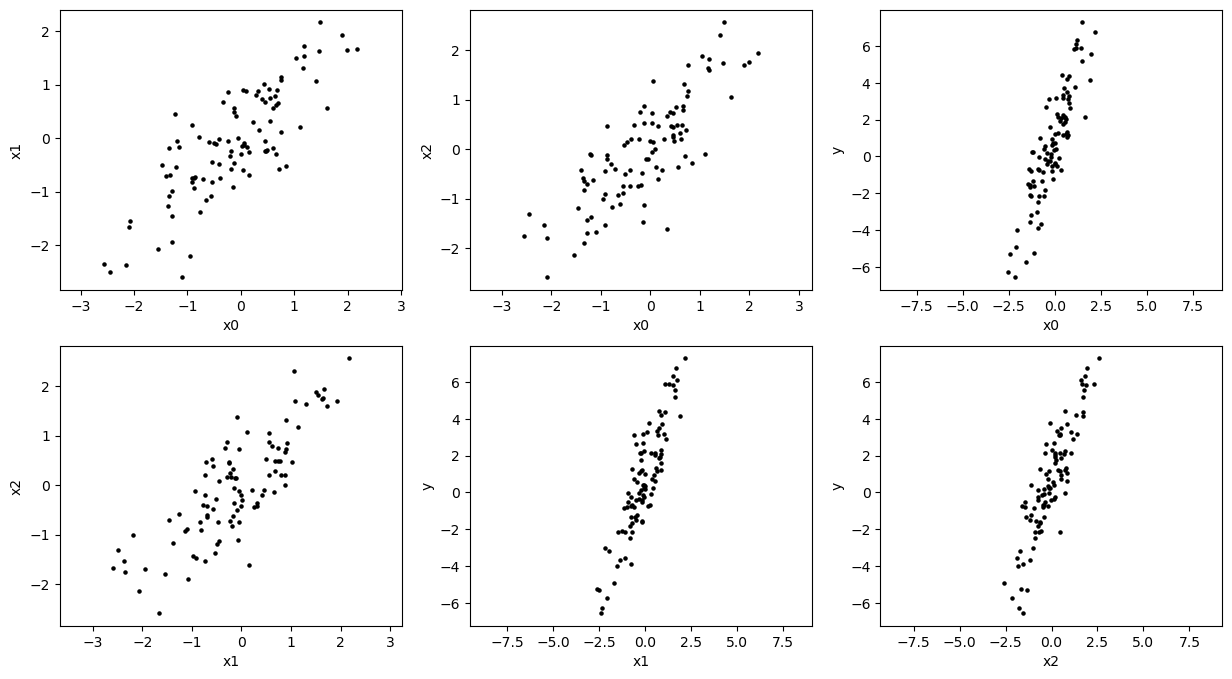

In [9]:
from itertools import combinations

def simulate_X_and_y_intercorrelated(true_m, true_b, true_σ, N=100, intercorrelation=0.8, seed=0):
    """Simulate a dataset with intercorrelated features.
    
    Creates three, x0, x1, and x2, with known intercorrelation, and their corresponding y,
    given provided coefficients: true_m, true_b, and true_σ.
    """
    if intercorrelation < 0 or intercorrelation > 1:
        raise ValueError("Intercorrelation must between 0 and 1.")

    np.random.seed(seed)
    cov = [
        [1, intercorrelation, intercorrelation], 
        [intercorrelation, 1, intercorrelation], 
        [intercorrelation, intercorrelation, 1],
    ]
    X = np.random.multivariate_normal([0, 0, 0], cov, size=N)
    y = np.dot(X, true_m) + true_b + true_σ

    return X, y


# Set known model parameters
# --------------------------
true_m = np.array([1, 1, 1])
true_b = 1
true_σ = np.random.normal(size=N) * true_m.mean()


# Simulate and display data
# -------------------------
X, y = simulate_X_and_y_intercorrelated(true_m, true_b, true_σ)
fig, ax = plt.subplots(2, 3, figsize=(15, 8))
ax = ax.flatten()
var_pairs = combinations([("x0", X[:, 0]), ("x1", X[:, 1]), ("x2", X[:, 2]), ("y", y)], 2)
for i, var_pair in enumerate(var_pairs):
    (xi_name, xi), (xj_name, xj) = var_pair
    ax[i].scatter(xi, xj, s=5, c="k")
    ax[i].set_xlabel(xi_name)
    ax[i].set_ylabel(xj_name)
    ax[i].axis("equal");

#### ... using `scipy` 📈

Similar to before, we define our linear model (now with multiple regressors) and fit it to some simulated data.

In [10]:
# Generate data (with known correlation between variables)
# -------------
X, y = simulate_X_and_y_intercorrelated(true_m, true_b, true_σ, intercorrelation=0.8)

# 1) Define the model
# -------------------
def linear_model(X, *params):
    m = np.array(params[:-1])
    b = params[-1]
    return np.dot(X, m) + b

# 2) Fit it!
# ----------
params_scipy, _ = curve_fit(linear_model, X, y, p0=[1, 1, 1, 1])

# 3) Compare the fitted parameters to the true ones
# -------------------------------------------------
print("True values:")
for i, m in enumerate(true_m):
    print(f"\tm{i}: ", m)
print("\tb: ", true_b)
print("\tσ (std): ", np.std(true_σ))

print("\nFit values:")
print("\tm0: ", params_scipy[0])
print("\tm1: ", params_scipy[1])
print("\tm2: ", params_scipy[2])
print("\tb: ", params_scipy[3])
print("\tσ (std): ", np.std(y - linear_model(X, *params_scipy)))

True values:
	m0:  1
	m1:  1
	m2:  1
	b:  1
	σ (std):  0.9286499323622

Fit values:
	m0:  0.9479072637585333
	m1:  1.063534801041869
	m2:  0.9417124292362552
	b:  0.9117802158363378
	σ (std):  0.9265817395410085


> **Excercise 4:**
> 
> Q 4.1: What aspect of the simulated data does the `intercorrelation` argument to the `simulate_X_and_y_intercorrelated` function control?
> 
> Q 4.2: Play around with it and observe what happens to the parameter fits. Describe what you see.

#### ... using PyMC 🚀

Below we repeat the process of defining a model in PyMC for this (only slightly) more complicated modeling problem. While not strictly required, I have added a few more bells and whistles that are in line with *best practices* for using PyMC (but I invite you to shave it down if you like breaking things to see how they work).

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

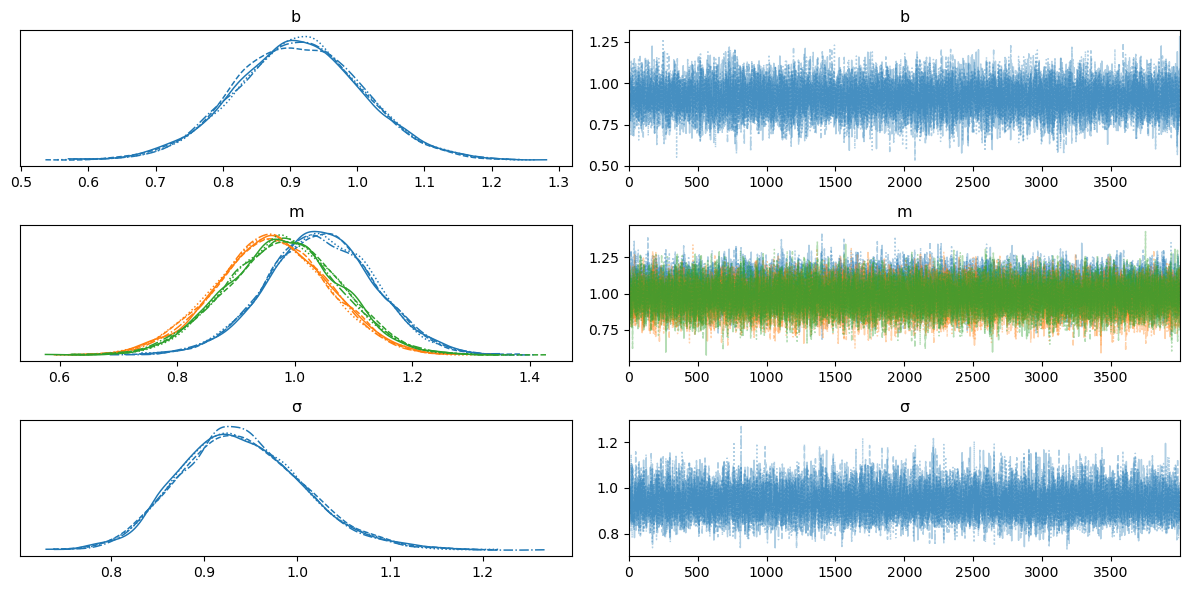

In [11]:
import arviz as az

# Generate data (with known correlation between variables)
# -------------
X, y = simulate_X_and_y_intercorrelated(true_m, true_b, true_σ, intercorrelation=0)  # <-- Play around with this!

# 1) Define the model
# -------------------
coords = {"M": np.arange(X.shape[1]), "N": np.arange(X.shape[0])}
with pm.Model(coords=coords):

    data = pm.Data("data", X, dims=("N", "M"))
    target = pm.Data("y", y, dims="N")

    m = pm.Normal('m', mu=1, sigma=1, dims="M")
    b = pm.Normal('b', mu=1, sigma=1)
    σ = pm.HalfNormal('σ', sigma=0.5)

    y_pred = pm.math.dot(data, m) + b

    pm.Normal('y_pred', mu=y_pred, sigma=σ, observed=y)
    
    # 2) Fit it!
    # ----------
    idata = pm.sample(draws=4000, tune=1000, chains=4, nuts_sampler="numpyro")

# 3) Visualize the posterior distribution
# ---------------------------------------
az.plot_trace(idata)
plt.tight_layout();

>
> **Excercise 5:** Some things changed in the PyMC model code compared to the previous one. I have explicitly defined `coords` (coordinates) of the data, `dims` (dimensions) of each variable, as well as the data that go into the model. I have also added two lines of utility code (from the wonderful library [`arviz`](https://www.arviz.org/en/latest/)) that visualizes the inference data—the left panel plots the marginal **posterior distributions** for each parameter, and the right panel plots the trace of the sampler. 
>
> Q 5.1: Try `pm.draw`ing from `m`. Explain why it has the shape it has.
>
> Q 5.2: Try adjust `intercorrelation` and rerun the code above. You should observe that the width of the posterior distribution increases (i.e. the parameter estimates become less certain). Why is that?
>
> Q 5.3: Recall that the point estimate of `m` returned by the traditional model fitter does not provide direct insight into uncertainty. All you get is a number. Comment on the advantage of using Bayesian regression when variables are correlated.
>
> Q 5.4: Think about what you could do if the variables were VERY correlated, but you had good prior knowledge of their individual coefficients. 

## Case: your target variable has varying certainty

It's fairly common that we have samples in our dataset that we trust more than others. Imagine that your target column is the fraction of messages sent by a mobile users, that qualify as seeking to buy illigal substances (maybe inferred in a preprocessing step by an LLM). User *0* has sent thousands of messages so the fractional estimate for this user is very accurate, but user *1* only sent 10 messages making the fraction esimate very uncertain ([on estimating uncertainty of Binomial distributions](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval)). If the predictor variables in this model are relevant demographic variables, naturally, you would want your model to fit *more* to the datapoints where you are more sure about the target variable value.

*... excercise to follow on fitting model with varying likelihood sigma ...*